#### Import library

In [23]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize
import numpy as np
import time
from sklearn.cluster import KMeans
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

## Parsing page with BeautifulSoup

Get data from website and create a BeautifulSoup class to parse document

In [ ]:
#create lists where store the data
title=[]
price=[]
n_room=[]
mq=[]
n_bathroom=[]
plan=[]
desc=[]
i=1
#iterate to take data from different page
for num in tqdm(range(1,1728)):
    url = str('www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag='+str(num))
    r = requests.get('https://' +url)
    data = r.text
    soup = BeautifulSoup(data,'html.parser')

    #iterate on the main class which contain all the data 
    for announcement in tqdm(soup.find_all('div', class_='listing-item_body--content')):
        #find all 'li' class which contain the data that we want and put them on the lists
        feature = announcement.find_all('li')
        if len(feature)>=6:
            #filter word on price
            feature_price = feature[0].text.strip()
            if ('PREZZO SU RICHIESTA' in feature_price )== True:
                break
            elif('%' in feature_price) == True:
                feature_price = feature_price.replace('.','').replace('€','').replace(' ','')
                price.append(feature_price[-19:-12])
            else:
                feature_price = feature_price.replace('.','').replace('€','').replace(' ','')
                price.append(feature_price)
            feature_n_room = feature[1].text[0]
            n_room.append(feature_n_room)
            feature_mq = feature[2].text[0:-12].replace('\xa0','')
            mq.append(feature_mq)
            feature_n_bathroom = feature[3].text[0:-5].replace('+','').replace('\xa0','')
            n_bathroom.append(feature_n_bathroom)
            feature_plan = feature[4].text[0:-7].strip()
            #check if there is a character inside plan data, if yes pop last element 
            if feature_plan.isalpha()==True:
                #title.pop()
                price.pop()
                n_room.pop()
                mq.pop()
                n_bathroom.pop()
                i+=0

            else:    
                plan.append(feature_plan)

                #find <a element where <href is present
                link=announcement.find('a', href=True)
                #check to solve the problem where the <href didn't have the complete link
                if ('https://' in link['href'])==True:
                    ann=requests.get(link['href'])
                else:
                    ann=requests.get('https://www.immobiliare.it'+link['href'])
                data1 = ann.text
                #create another bs4 element to access in the specific link and take commplete text from announcement
                soup1 = BeautifulSoup(data1,'html.parser')
                #access to link and take complete text
                a=soup1.find('div', attrs={'role':'contentinfo'}).text.strip()
                desc.append(a)
                title.append('announcement_'+str(i))
                i+=1


    time.sleep(1)

            

### Load the list

After download all announcement we have save all list. To load all list run the follow cel (file are stored in folder DATA list in our repository).

In [12]:
with open(r'C:\Users\Daniele\Desktop\liste download\desc', 'rb') as f:
    desc = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\plan', 'rb') as f:
    plan = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\n_bathroom', 'rb') as f:
    n_bathroom = pickle.load(f)
    
with open(r'C:\Users\Daniele\Desktop\liste download\mq', 'rb') as f:
    mq = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\n_room', 'rb') as f:
    n_room = pickle.load(f)

with open(r'C:\Users\Daniele\Desktop\liste download\price', 'rb') as f:
    price = pickle.load(f)
    
with open(r'C:\Users\Daniele\Desktop\liste download\title', 'rb') as f:
    title = pickle.load(f)
    
with open(r'C:\Users\Daniele\Desktop\liste download\processed', 'rb') as f:
    processed_list = pickle.load(f)      

In [ ]:
print(len(title))
print(len(price))
print(len(n_room))
print(len(mq))
print(len(n_bathroom))
print(len(plan))
print(len(desc))

Now we store the data in a pandas DataFrame

In [26]:
table=pd.DataFrame({'Annuncio':title,
                    'Prezzo':price,
                    'Camere':n_room,
                    'Superficie':mq,
                    'Bagni':n_bathroom,
                    'Piano':plan})
#used to remove a \n inside "Piano" coloumn
Information_cluster =table.set_index('Annuncio')
Information_cluster.head(5)

,Prezzo,Camere,Superficie,Bagni,Piano
Annuncio,,,,,
announcement_1,225000,2,50,1,1
announcement_2,375000,3,120,1,3
announcement_3,450000,5,150,2,3
announcement_4,315000,3,92,2,5
announcement_5,579000,5,160,2,2


Take all the announcement from page

In [15]:
#only see if the dataframe is the data are correct, then i remove this
annuncio=pd.DataFrame({'Annuncio':desc})
annuncio

,Annuncio
0,PAPILLO EUR in elegante complesso residenziale...
1,"Pigneto, Appartamento in Vendita, libero lumin..."
2,Zona EUR - Viale Cesare Pavese - Via Salvatore...
3,Fino al 31/12/2018 le spese relative l’onorari...
4,"Eur, Appartamento in vendita via Cesare Pavese..."
5,"San Giovanni, Appartamento in Vendita, adiacen..."
6,"San Giovanni, Appartamento in Vendita, finemen..."
7,Rif: 18105 - PORTA DI ROMA - Via Carlo Dapport...
8,Nelle immediate vicinanze di viale Cortina D’A...
9,A pochi passi della prestigiosa cornice di Pia...


Function to preprocess all text in the announcement

In [ ]:
def preprocess(text):
    text = text.lower()
    # removing '\n'
    text = text.replace('\\n', ' ')
    # removing punctuation
    tokenizer = regexp_tokenize(text, "[\w\$]+")
    # filter the non stopwords
    filtered = [w for w in tokenizer if not w in stopwords.words('italian')]
    ps = PorterStemmer()
    # removing the stem
    filtered = [ps.stem(word) for word in filtered]
    return filtered

Pre process all the announcement and put in a list

In [ ]:
processed_list=[]
for i in desc:
    processed_list.append(preprocess(i))    

We check the number of unique word that we have

In [17]:
flat_list = [item for sublist in processed_list for item in sublist]
len(list(set(flat_list)))

785

The processed_list composed by a nested list of word is converted to a list of string and then a data frame with wordId and all text from the announcement processed is created.

In [24]:
b=[' '.join(i) for i in processed_list]
#to generate teh wordId
WordId=[int(i) for i in range(1,len(b)+1)]
#creating dataframe with wordId and all text from the announcement processed
df1 = pd.DataFrame({'wordId': WordId, 'parole': b})

We have used pandas and numpy to compute Tf-IDF in all dataframe

In [27]:
# Tokenize and generate count vectors
word_vec = df1.parole.apply(str.split).apply(pd.value_counts).fillna(0)
# Compute term frequencies
tf = word_vec.divide(np.sum(word_vec, axis=1), axis=0)
# Compute inverse document frequencies
idf = np.log10(len(tf) / word_vec[word_vec > 0].count())
# Compute TF-IDF vectors
tfidf = np.multiply(tf, idf.to_frame().T)
#L2 (Euclidean) normalization
l2_norm = np.sum(np.sqrt(tfidf), axis=1)
#Normalized TF-IDF vectors
tfidf_norm = (tfidf.T / l2_norm).T
#put in a dataframe
Description_cluster=pd.DataFrame(tfidf_norm)
word_column=['word_'+str(i) for i in range(1,len(Description_cluster.columns)+1) ]
Description_cluster.columns=word_column
Description_cluster=Description_cluster.set_index(table.index)
Description_cluster.head(10)

,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,...,word_776,word_777,word_778,word_779,word_780,word_781,word_782,word_783,word_784,word_785
0,0.018385,0.009192,0.00766,0.003064,0.003064,0.003064,0.003064,0.000290,0.001532,0.001118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000052,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000138,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000371,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000152,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000273,0.000000,0.001052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Saving data to csv

In [ ]:
Description_cluster.to_csv(r'C:\Users\Daniele\Desktop\Matrix_TfIdf.csv')
Information_cluster.to_csv(r'C:\Users\Daniele\Desktop\Matrix.csv')

# Clustering

Before start we check with elbow test the number of cluster to assign with Elbow method. Both Dataframe are converted to a matrix

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.61it/s]


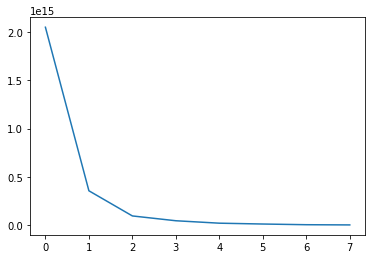

In [29]:
#convert Information cluster to a matrix
information_matrix=Information_cluster.values
elbow=[]
for i in tqdm( range(2,10)):
    km =KMeans(n_clusters=int(i), init='k-means++', tol=0.0001).fit(information_matrix)
    elbow.append(km.inertia_)
plt.plot(elbow)
plt.show()    

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:52<00:00,  6.51s/it]


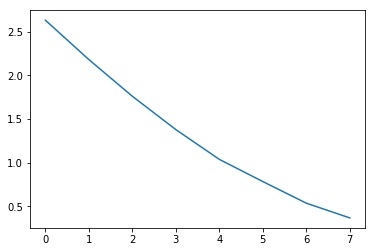

In [30]:
#convert Desciption cluster to a matrix
Description_matrix =Description_cluster.values
elbow=[]
for i in tqdm( range(2,10)):
    km =KMeans(n_clusters=int(i), init='k-means++', tol=0.0001).fit(Description_matrix)
    elbow.append(km.inertia_)
plt.plot(elbow)
plt.show()    

In [ ]:
# Using sklearn
km =KMeans(n_clusters=5, init='k-means++', tol=0.0001).fit(Description_matrix)
km1=KMeans(n_clusters=5, init='k-means++', tol=0.0001).fit(information_matrix)
# Get cluster assignment labels
labels = km.labels_
labels1 = km1.labels_
#put the result of cluster in a dataframe
results = pd.DataFrame([second_mat.index,labels]).T
results1 = pd.DataFrame([table.index,labels]).T

In [ ]:
final_result=pd.merge(results, results1, on=0)
final_result

In [ ]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection / union)